Changelog
- 3 Oct
    - Creation
    - Add `Tables`, `DataValueInterfaces` and `DataAPI` because `PGFPlots` wasn't getting precompiled
    - Wrote functions for regressogram,local_averaging and Gaussian kernel regression
    - Works fine on Glass. Regressogram not working on motorcycle dataset
- 7 Oct
    - Motorcyle regressogram works; was simply a matter of name confusion between glass and motorcyle
- 8 Oct
    - All the other questions
    - Saving pgfplots
- 16 Oct
    - Hw2 local linear regression implementation

In [1]:
# Imports
using DelimitedFiles # To use readdlm
using PGFPlots
using StatsBase # To use mean
using Distributions # To call Normal distribution
using Random # To seed

#### function definitions

In [6]:
# function: make even bins
"""
    function make_bins(num_bins,lo,hi)
- Make `num_bins` even bins from `lo` to `hi`

# Example
```julia
bin_lefts = make_bins(10,0.29,3.50)
```
"""
function make_bins(num_bins,lo,hi;verbosity=false)
    bin_array = fill(0.,num_bins)
    if verbosity print("lo=$lo,hi=$hi,num_bins=$num_bins\n") end
    width = (hi-lo)/num_bins
    if verbosity print("width=$width\n") end
    for i in 1:num_bins
        bin_array[i] = lo+width*(i-1)
    end
    return bin_array
end

# function: Create dict with bins and corresponding average outputs
"""
    function binned_y_average(binned_y_train)
- Given a dict with bin number as keys and array of output values as value
- Return dict with same bin number keys but just the corresponding mean value

# Example
```julia
binavg_y_train = binned_y_average(binned_y_train)
```
"""
function binned_y_average(binned_y_train)
    binavg_y_train = Dict{Int64,Float64}()
    for (k,v) in binned_y_train
        binavg_y_train[k] = mean(v)
    end
    return binavg_y_train
end

binned_y_average

In [7]:
# function: Regressogram
"""
    function regressogram(num_bins,lo,hi,num_test,x_train,y_train)
- Divide input (covariate) range into `num_bins` from `lo` to `hi`
- Run regressogram on `num_test` evenly spaced input points in the range `lo` to `hi`
- Training is done using `x_train` and `y_train`

# How it works
- Collect training data input values into uniform bins
- Caculate corresponding average y value
- Test input is placed into bin and associated output is average computed above

# Examples
```julia
g = readdlm("glass.dat");y_train = Float64.(a[2:end,2]);x_train=Float64.(a[2:end,5]);
p_regressogram = regressogram(10,0.29,3.50,200,x_train,y_train)
```
"""
function regressogram(num_bins,lo,hi,num_test,x_train,y_train)
    bin_lefts = make_bins(num_bins,lo,hi);

    binned_y_train = Dict{Int64,Array{Float64,1}}()
    binned_x_train = Dict{Int64,Array{Float64,1}}()
    # initialize the dictionary
    for i in 1:num_bins
        binned_y_train[i] = []
        binned_x_train[i] = []
    end
    # Go over the training set and push the y values into bins to take mean later
    for (j,x_train_sample) in enumerate(x_train)
        push!(binned_y_train[argmin(abs.(x_train_sample .- bin_lefts))],y_train[j])
        push!(binned_x_train[argmin(abs.(x_train_sample .- bin_lefts))],x_train_sample)
    end
    binavg_y_train = binned_y_average(binned_y_train)
    
    x_test = make_bins(num_test,lo,hi);
    y_test = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        y_test[i] = binavg_y_train[argmin(abs.(x_test_sample .- bin_lefts))]
    end
    plot_regressogram = PGFPlots.Plots.Scatter(x_test,y_test,legendentry="Regressogram");
    return plot_regressogram
end

regressogram

In [8]:
# function: local_averaging
"""
    function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
`lo` and `hi` are used to create `num_test` test points. They don't directly work in the algo

# How it works
- For every test input, consider the training inputs within `bandwidth` from the test input
- The associated test output is the average training outputs of these points within the bandwidth

# Examples
```julia
p_lavg = local_averaging(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_localavg = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        x_neighbors = []
        y_neighbors = []
        for (kk,x_train_sample) in enumerate(x_train)
            if abs(x_train_sample-x_test_sample) <= bandwidth
                push!(x_neighbors,x_train_sample)
                push!(y_neighbors,y_train[kk])
            end
        end
        y_test_localavg[i] = mean(y_neighbors)
    end
    plot_localavg = PGFPlots.Plots.Scatter(x_test,y_test_localavg,legendentry="Local Averaging");
    return plot_localavg
end

local_averaging

In [9]:
# function: Gaussian Kernel
"""
    function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)

# How it works
- For every test input, assign weights to all the training points
- These weights determine how much every training point contributes to the test output
- The weights is calculated based on the Gaussian pdf form of distance calculator

# Examples
```julia
p_gauss = gaussian_kernel(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
    end
    plot_gaussian = PGFPlots.Plots.Scatter(x_test,y_test_gaussian,legendentry="Gaussian Kernel");
    return plot_gaussian
end

gaussian_kernel

#### glass dataset

In [ ]:
# Compare various regressions for glass dataset
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_g,y_train_g,legendentry="Train");
num_bins_g = 10 
lo_g=0.29
hi_g=3.50
num_test_g=200
bandwidth_g=0.321;
p_regressogram = regressogram(num_bins_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p_lavg = local_averaging(bandwidth_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p_gauss = gaussian_kernel(bandwidth_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
fig = PGFPlots.Axis([plot_trainingdata,p_regressogram,p_lavg,p_gauss],title="Glass Dataset",
    xlabel="Aluminium Content",ylabel="Refractive Index",legendPos="outer north east")
display(fig)
PGFPlots.save("figs/glass.tikz",fig)

#### motorcycle dataset

In [ ]:
# Compare approaches on motorcyle dataset
m = readdlm("motor.dat"); y_train_motor = Float64.(m[2:end,2]); x_train_motor = Float64.(m[2:end,1]);
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_motor,y_train_motor,legendentry="Train");
num_bins = 20; lo_m=2.4;hi_m=57.6;num_test=200;bandwidth=2.76;
p_reg = regressogram(num_bins,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
p_lavg = local_averaging(bandwidth,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
p_gauss = gaussian_kernel(bandwidth,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
fig_m = PGFPlots.Axis([plot_trainingdata,p_reg,p_lavg,p_gauss],title="Motorcycle Dataset",
    xlabel="Time",ylabel="Acceleration",legendPos="outer north east")
display(fig_m)
PGFPlots.save("figs/motor.tikz",fig_m)

## part b) Bias variance tradeoff

### Part 1
- $r(x) = x, \sigma= 1, n = 100$

In [ ]:
# Let's generate the synthetic data
Random.seed!(1)
x = collect(0.01:0.01:1);y = x + rand(Normal(0,1),100);
r_x = x;
p_noisy = PGFPlots.Plots.Scatter(x,y,legendentry="noisy data")
p_ground = PGFPlots.Plots.Scatter(x,r_x,legendentry="ground truth")
PGFPlots.Axis([p_noisy,p_ground],xlabel="x",ylabel="y",legendPos="outer north east")

In [ ]:
# Let's train our regressogram and local averaging and plot their output
p_regressogram = regressogram(10,0,1,200,x,r_x)
p_lavg = local_averaging(0.1,0,1,200,x,r_x)
fig_b1 = PGFPlots.Axis([p_ground,p_regressogram,p_lavg],legendPos="outer north east")
display(fig_b1)
PGFPlots.save("figs/b1.tikz",fig_b1)

### Part 2
- $r(x) = sin(2\pi x),\sigma=1,n=99$

In [ ]:
# function: Gaussian Kernel for MSE
"""
    function gaussian_kernel_for_MSE(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
Returns the analytical mean squared error

# How it works
- For every test input, assign weights to all the training points
- These weights determine how much every training point contributes to the test output
- The weights is calculated based on the Gaussian pdf form of distance calculator
- sigma is the std. dev of the corrupting noise on the training data

# Examples
```julia
gaussian_kernel_for_MSE(0.1,1/99,1.,99,x,r_x,1.)
```
"""
function gaussian_kernel_for_MSE(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    var = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
        
        var[i] = sum(weights.^2)*sigma*sigma/(sum(weights)^2)
    end
    n = length(x_train)
    
    variance_analytical = sum(var)/n
    
    bias_analytical = sum((y_train .- y_test_gaussian).^2)/n
    
    p_true = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="ground truth")
    p_analytical = PGFPlots.Plots.Scatter(x_train,y_test_gaussian,legendentry="analytical MSE")
    p_axis = PGFPlots.Axis([p_true,p_analytical],xlabel="x",ylabel="y")
#     display(p_axis)
    return bias_analytical + variance_analytical
end

In [ ]:
# Run the Gaussian kernel on noise free data for the MSE calculation
gaussian_kernel_for_MSE(0.1,1/99,1.,99,x,r_x,1.)

In [ ]:
# function: Gaussian kernel to compute sampling based MSE
"""
- Returns the square loss of the dataset
- Is subsequently used to compute the sampling based MSE by averaging the square loss over diff datasets

# Examples
```julia
gaussian_kernel_square_loss(0.1,1/99,1.,99,x,y,r_x)
```
"""
function gaussian_kernel_square_loss(bandwidth,lo,hi,num_test,x_train,y_train,y_true)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
    end
    return sum((y_true .- y_test_gaussian).^2)/num_test
end

In [ ]:
# Perform sampling based MSE compute on 100 datasets
n = 99
x = fill(0.,n,)

sigma = 1.
for i in 1:n
    x[i] = i/n
end
r_x = sin.(2*pi*x)
seeds = collect(1:100)
square_loss = fill(0.,length(seeds),)
for seed in seeds
    Random.seed!(seed)
    y = r_x + rand(Normal(0,sigma),n)
    square_loss[seed] = gaussian_kernel_square_loss(0.1,1/99,1.,99,x,y,r_x)
end

count = 0; cumsumloss=0
expected_sq_loss = fill(0.,length(square_loss),)
for loss in square_loss
    cumsumloss += loss
    count += 1
    expected_sq_loss[count] = cumsumloss/count
end
print("Final expected_sq_loss = $(expected_sq_loss[end])\n")
fig_b2 = PGFPlots.Axis([PGFPlots.Plots.Scatter(collect(1:100),expected_sq_loss)],
    xlabel="Dataset number",ylabel="Average sampling MSE")
display(fig_b2)
PGFPlots.save("figs/b2.tikz",fig_b2)

### Part 3
- $r(x) = sin(10 \pi x),\sigma=0.1,n = 99$
- Plot for bandwidth = $0.001,0.05,0.2,100$

In [ ]:
# function: Plot variance bands around the expected estimate using Gaussian kernel
"""
# Examples
```julia
gaussian_kernel_with_variance_bands(0.05,1/n,1,n,x,r_x,sigma)
```
"""
function gaussian_kernel_with_variance_bands(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    var = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
        
        var[i] = sum(weights.^2)*sigma*sigma/(sum(weights)^2)
    end
    
    p_true = PGFPlots.Plots.Linear(x_train,y_train,legendentry="ground truth",style="red")
    p_expected = PGFPlots.Plots.Linear(x_train,y_test_gaussian,legendentry="exp", style="blue")
    p_add = PGFPlots.Plots.Linear(x_train,y_test_gaussian+sqrt.(var),legendentry=L"exp+\sqrt{var}",
    style="gray")
    p_subtract = PGFPlots.Plots.Linear(x_train,y_test_gaussian-sqrt.(var),legendentry=L"exp-\sqrt{var}",
    style = "yellow")
    p_noisy = PGFPlots.Plots.Scatter(x,y_train+rand(Normal(0,sigma),num_test),legendentry="noisy data")
    p_axis = PGFPlots.Axis([p_true,p_expected,p_add,p_subtract,p_noisy],
        xlabel="x",ylabel="y",title="bandwidth=$(bandwidth)",legendPos="outer north east")
    return p_axis
end

In [ ]:
n = 99;sigma=0.1
bandwidth = 100
x= fill(0.,n,)
for i in 1:n
    x[i] = i/n
end
r_x = sin.(10*pi*x)
fig_b3 = gaussian_kernel_with_variance_bands(bandwidth,1/n,1,n,x,r_x,sigma)
display(fig_b3)
PGFPlots.save("figs/b3_$(bandwidth).tikz",fig_b3)

### Part 4
- $r(x) = 0.5,\sigma=1,n=99$
- Plot for bandwidths: 0.001,0.05,0.2,100

In [ ]:
n = 99;sigma=1
bandwidth = 100
x= fill(0.,n,)
for i in 1:n
    x[i] = i/n
end
r_x = fill(0.5,length(x),)
fig_b4 = gaussian_kernel_with_variance_bands(bandwidth,1/n,1,n,x,r_x,sigma)
display(fig_b4)
PGFPlots.save("figs/b4_$(bandwidth).tikz",fig_b4)

### Part 5
- $r(x)=cos(2\pi x),\sigma=1$

In [ ]:
# function: Analytical MSE as a function of number of data points and bandwidth
"""
Compute the analytical MSE using the Gaussian kernel

# Examples
```julia
analytical_MSE(num_points,1,bandwidth)
```
"""
function analytical_MSE(n,sigma,bandwidth)
    x = fill(0.,n)
    for i in 1:n
        x[i]=i/n
    end
    r_x = cos.(2*pi*x)
    MSE_anal = gaussian_kernel_for_MSE(bandwidth,1/n,1.,n,x,r_x,sigma)
    return MSE_anal
end

In [ ]:
num_examples = [5, 20, 80, 320, 1280]
bandwidths = [0.02, 0.03, 0.048, 0.063, 0.08, 0.1, 0.12, 0.15, 0.19]
best_bandwidth = fill(0.,length(num_examples),)
for (i,num_points) in enumerate(num_examples)
    print("n = $(num_points)\n")
    MSE_anal_min = 10e6
    h_min = 100
    for bandwidth in bandwidths
#         print("h = $(bandwidth)\n")
        MSE_anal = analytical_MSE(num_points,1,bandwidth)
        if MSE_anal < MSE_anal_min
#             print("MSE_anal = $(MSE_anal)\n")
            MSE_anal_min = MSE_anal
            h_min = bandwidth
        end
    end
#     print("best_bandwidth = $(h_min)\n")
    best_bandwidth[i] = h_min
end
@show best_bandwidth
fig_5 = PGFPlots.Axis([PGFPlots.Plots.Scatter(num_examples,best_bandwidth)],
    xlabel="Number of data points",ylabel="Best bandwidth")
display(fig_5)
PGFPlots.save("figs/b5.tikz",fig_5)

# **********************Homework 2 begins***********

In [10]:
# function: Local linear regression
"""
    function local_linear_reg(bandwidth,lo,hi,num_test,x_train,y_train)

# How it works
- Uses the Gaussian kernel
- Implements the formula given in the problem statement

# Examples
```julia
local_linear_reg(0.02,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
```
"""
function local_linear_reg(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_local_lin_reg = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        w = fill(0.,length(x_train),)
        u = fill(0.,length(x_train),)
        
        # Compute the w and u
        for (kk,x_train_sample) in enumerate(x_train)
            u[kk] = x_train_sample-x_test_sample
            w[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*(u[kk]/bandwidth)^2)
        end
        
        # Compute the summation components within b
        b_first = 0.;b_second = 0.;
        for ii in 1:length(x_train)
            b_first += w[ii]*u[ii]*u[ii]
            b_second += w[ii]*u[ii]
        end
        
        # Compute b
        b = fill(0.,length(x_train),)
        for mm in 1:length(x_train)
            b[mm] = w[mm]*(b_first-u[mm]*b_second)
        end
        
        l = fill(0.,length(x_train),)
        for ff in 1:length(x_train)
            l[ff] = b[ff]/sum(b)
        end
        
        y_test_local_lin_reg[i] = (sum(l.*y_train))
    end
    plot_local_lin_reg = PGFPlots.Plots.Scatter(x_test,y_test_local_lin_reg,
        legendentry="h = $(bandwidth)");
    return plot_local_lin_reg
end

local_linear_reg

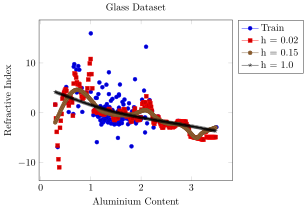

In [19]:
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_g,y_train_g,legendentry="Train");

lo_g=0.29
hi_g=3.50
num_test_g=200
bandwidth_g=0.321;

p1 = local_linear_reg(0.02,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p2 = local_linear_reg(0.15,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p3 = local_linear_reg(1.,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
fig = PGFPlots.Axis([plot_trainingdata,p1,p2,p3],title="Glass Dataset",
    xlabel="Aluminium Content",ylabel="Refractive Index",legendPos="outer north east")
display(fig)
#PGFPlots.save("figs/hw2/1a1.tikz",fig)

# Part a.2
$r(x) = x$

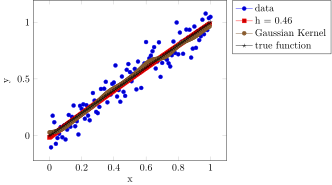

In [34]:
data = readdlm("a2data.csv",',')
x_train = Float64.(data[2:end,2])
y_train = Float64.(data[2:end,3])
p_data = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="data")
p_local_lin_reg = local_linear_reg(0.46,0.,1.,200,x_train,y_train)
p_gaussian_kernel= gaussian_kernel(0.05,0.,1.,200,x_train,y_train)
p_truth = PGFPlots.Plots.Scatter(collect(0:0.01:1),collect(0:0.01:1),legendentry="true function")
PGFPlots.Axis([p_data,p_local_lin_reg,p_gaussian_kernel,p_truth],
    xlabel="x",ylabel="y",legendPos="outer north east")

In [10]:
# Cleaning up glass data i.e. leave only what's required for python to load in
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])

x_train = reshape(x_train_g,length(x_train_g),1)
y_train = reshape(y_train_g,length(y_train_g),1)
glass_cleaned = hcat(x_train,y_train)


214×2 Array{Float64,2}:
 1.1    3.01
 1.36  -0.39
 1.54  -1.82
 1.29  -0.34
 1.24  -0.58
 1.62  -2.04
 1.14  -0.57
 1.05  -0.44
 1.37   1.18
 1.36  -0.45
 1.56  -2.29
 1.27  -0.37
 1.4   -2.11
 ⋮          
 2.42  -2.86
 1.99  -1.42
 2.27  -1.83
 1.8   -0.68
 1.87  -1.55
 1.82   0.31
 2.74  -1.6 
 2.88  -1.77
 1.99  -1.15
 2.02   2.65
 1.94  -1.49
 2.08  -0.89

In [12]:
open("glass_cleaned.txt", "w") do io
    writedlm(io,glass_cleaned)
end